# Notebook description
<!---define operatorname var-->
$\DeclareMathOperator{\Var}{Var}$
<!---define operatorname var-->

This notebook looks at the mean, variance, and SNR of a synapse with input spike train with interspike intervals (ISIs) following a [gamma distribition](http://en.wikipedia.org/wiki/Gamma_distribution) with rate $\lambda$ and shape parameter $k$.

The pdf of the gamma distribution is given by
$$
f_X(x) = \frac{\lambda^k}{\Gamma(k)}x^{k-1}e^{-\lambda x} \quad x>0
$$

We are particularly interested in cases when $k$ is a positive integer, in which case

$$
f_X(x) = \frac{\lambda^k}{(k-1)!}x^{k-1}e^{-\lambda x} \quad x>0
$$

which is the pdf of the [Erlang distribution](http://en.wikipedia.org/wiki/Erlang_distribution). The Erlang distribution arises from the sum of $k$ [exponential distributions](http://en.wikipedia.org/wiki/Exponential_distribution) with rate $\lambda$. The Erlang distribution can model the output spiking statistics of an accumulator that takes Poisson spikes as input. 

The accumulator sums the decode weighted incoming spikes. When the accumulator sum reaches a predefined threshold, the accumulator outputs a spike itself and subtracts the threshold value from its current sum. 

Currently, we assume that the output spikes of neuron follows Poisson statistics. If we scale the spikes by decode weights and pipe them into an accumulator, we assume the accumulator returns a uniform spike process. In this notebook, we seek to refine this assumption.

# Summary of results

<div style="display:block; border: 1px solid black; padding: 15px;background-color: #EEEEFF;margin: 10px">
\begin{align*}
E[X] &= \frac{\lambda}{k} \\
\Var(X) &= \frac{\lambda}{2\tau k}\left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}\right) \\ \\
SNR &= \frac{\sqrt{2\lambda\tau/k}}
    {\sqrt{\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}}} \\
 &\approx
\begin{cases}
\sqrt{2\lambda\tau/k} & \textrm{at low }\lambda\tau \\
\sqrt{2\lambda\tau} & \textrm{at high }\lambda\tau \\
\end{cases}
\end{align*}
</div>

# Derivations

The gamma-distributed ISIs define a [renewal process](http://en.wikipedia.org/wiki/Renewal_theory). Each spike is an event, and the intervals between events are i.i.d. according to the gamma distribution. We consider statistics of a synapse that is exponentially filtering the spikes. At a given point in time, the synapse is a function of the spikes arriving earlier in time. However, because the gamma distribution is not memoryless, the distribution of the interval between the current time and the first, previous spike is not identical to the ISI distribution. The first and second moments (derived [here](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/theory/filtered_renewal_processes.ipynb#Filtered-renewal-process-with-different-first-interval)) of an exponentially filtered renewal process with a different first interval distribution are given by 

\begin{align*}
E[X] &= \frac{1}{\tau}E\left[e^{-T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-T/\tau}\right]^i \\
E[X^2] &= \frac{1}{\tau^2}E\left[e^{-2T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-2T/\tau}\right]^i
    \left(1 + 2\sum_{j=1}^{\infty}E\left[e^{-T/\tau}\right]^j\right) \\
\end{align*}

where $T_1$ describes the first interval (interval between current time and first, previous spike), and $T$ describes the ISIs. By definition, $T\sim\mathrm{Gamma}(k, \lambda)$. $T_1$ can be decomposed as $T_1=UT^*$ where $U$ and $T^*$ are independent, $U\sim\mathrm{Uniform}(0,1)$, and $T^*$ is a random variable describing ISI containing the current point in time. Perhaps surprisingly, $T^*\neq T$. This is known as the [inspection paradox](http://en.wikipedia.org/wiki/Renewal_theory#The_inspection_paradox). To develop some intuition, imagine that we first generate all of the spike times. Next we select a point in time by throwing a dart somewhere along the time axis. Our dart is biased to fall in larger ISIs simply because they are larger. Therefore $T^*$ is biased by the size of the interval. The PDF of $T^*$ is given by

$$
f_{T^*}(t)=\frac{tf_T(t)}{E[T]}
$$

so the PDF of $T_1$ ends up bing

$$
f_{T_1}(t)=\frac{1-F_T(t)}{E[T]}
$$

Below, we derive expressions for the synapse mean, variance, and SNR. Supplementary derivations for intermediate steps are in the [appendix](#Supplementary-derivations) (i.e. if the derivation seems to skip a step, it will be found in the appendix).

## Synapse mean

\begin{align*}
E[X] &= \frac{1}{\tau}E\left[e^{-T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-T/\tau}\right]^i \\
 &= \frac{1}{\tau}\frac{\lambda\tau}{k}\left(1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k\right)
    \sum_{i=0}^{\infty}\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{ki} \\
 &= \frac{1}{\tau}\frac{\lambda\tau}{k}\left(1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k\right)
    \frac{1}{1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{k}} \\
 &= \frac{\lambda}{k}
\end{align*}

## Synapse variance

\begin{align*}
E[X^2] &= \frac{1}{\tau^2}E\left[e^{-2T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-2T/\tau}\right]^i
    \left(1 + 2\sum_{j=1}^{\infty}E\left[e^{-T/\tau}\right]^j\right) \\
 &= \frac{1}{\tau^2}\frac{\lambda\tau}{2k}\left(1-\left(\frac{\lambda\tau}{2+\lambda\tau}\right)^k\right)
    \sum_{i=0}^{\infty}\left(\frac{\lambda\tau}{2+\lambda\tau}\right)^{ki}
    \left(1 + 2\sum_{j=1}^{\infty}\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{kj}\right) \\
 &= \frac{\lambda}{2k\tau}\left(1-\left(\frac{\lambda\tau}{2+\lambda\tau}\right)^k\right)
    \frac{1}{1-\left(\frac{\lambda\tau}{2+\lambda\tau}\right)^k}
    \left(1 + 2\frac{\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k}
    {1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k}\right) \\
 &= \frac{\lambda}{2k\tau}\left(
    \frac{1+\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k}
    {1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k}\right) \\
 &= \frac{\lambda}{2k\tau}\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k} \\
\end{align*}

Therefore,

\begin{align*}
\Var(X) &= E[X^2]-E[X]^2 \\
 &= \frac{\lambda}{2k\tau}\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \left(\frac{\lambda}{k}\right)^2 \\
 &= \frac{\lambda}{2\tau k}\left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}\right) \\
\end{align*}

## Synapse SNR

\begin{align*}
SNR &= \frac{E[X]}{\sqrt{\Var(X)}} \\
 &= \frac{\frac{\lambda}{k}}
    {\sqrt{\frac{\lambda}{2\tau k}\left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}\right)}} \\
 &= \frac{\sqrt{2\lambda\tau/k}}
    {\sqrt{\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}}} \\
 &= \sqrt{\frac{2\lambda\tau/k}
    {\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}}} \\
 &\approx
\begin{cases}
\sqrt{2\lambda\tau/k} & \textrm{at low }\lambda\tau \\
\sqrt{2\lambda\tau} & \textrm{at high }\lambda\tau \\
\end{cases}
\end{align*}

(proof [below](#SNR-limit-high-$\lambda\tau$)) which is similar to a Poisson synapse with rate $\lambda/k$, which would have $SNR=\sqrt{2\lambda\tau/k}$.

# Simulation setup

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import gamma
import scipy

s = np.random.seed(2)
rng = np.random.RandomState(s)

In [2]:
def th_mean(lam, k, tau):
    return lam/k

def th_var(lam, k, tau):
    x = lam*tau
    a = lam/(2*tau*k)
    b_num = (1+x)**k+x**k
    b_den = (1+x)**k-x**k
    b = b_num/b_den
    c = 2*lam*tau/k
    ret = a*(b-c)
    return ret

def th_snr(lam, k, tau):
    x = lam*tau
    a = np.sqrt(2*x)
    b_num = (1+x)**k+x**k
    b_den = (1+x)**k-x**k
    b = b_num/b_den
    c = 2*x/k
    ret = a / np.sqrt(k*(b-c))
    return ret

def get_snr(mu, var):
    return mu/np.sqrt(var)

In [3]:
def check_theory(lams, k, tau=.01, n_tau_ss=10, n_tau=30, n_samples=100, n_trials=300, k_normalize=False):
    min_nspikes = 100
    nfreqs = len(lams) # number of frequencies to test
    mean_obs = np.zeros(nfreqs)
    var_obs = np.zeros(nfreqs)

    for lam_idx, lam in enumerate(lams):
        nspikes = max(2*int(n_tau*tau*lam/float(k)), min_nspikes)
        isi = rng.gamma(k, 1./lam, (n_trials, nspikes))
        spike_times = np.cumsum(isi, axis=1)
        x = np.zeros((n_trials, n_samples))
        obs_trial_mean = np.zeros(n_trials)
        for trial_idx in xrange(n_trials):
            t_samples = rng.uniform(0., spike_times[trial_idx][-1]-n_tau_ss*tau, n_samples)
            for sample_idx, t in enumerate(t_samples):
                tp = spike_times[trial_idx]-t
                tp = tp[tp>=0]
                x[trial_idx, sample_idx] = np.sum(np.exp(-tp[tp>=0]/tau))/tau
        mean_obs[lam_idx] = np.mean(x)
        var_obs[lam_idx] = np.var(x)
    snr_obs = get_snr(mean_obs, var_obs)

    mean_th = th_mean(lams, k, tau)
    var_th = th_var(lams, k, tau)    
    snr_th = th_snr(lams, k, tau) 
    
    fig, axs = plt.subplots(ncols=3, figsize=(12,4), sharex=True)
    x = lams*tau
    if k_normalize:
        x /= k
        mean_obs /= k
        mean_th /= k
        var_obs /= k**2
        var_th /= k**2

    axs[0].plot(x, mean_obs*tau, 'b', label='simulation')
    axs[0].plot(x, mean_th*tau, 'r', label='theory')
    axs[0].legend(loc='upper left', fontsize=12)
    
    axs[1].plot(x, var_obs*tau**2, 'b', label='simulation')
    axs[1].plot(x, var_th*tau**2, 'r', label='theory')
    axs[1].set_title(r'$k=%d$' % k, fontsize=20)
    
    axs[2].plot(x, snr_obs, 'b', label='simulation')
    axs[2].plot(x, snr_th, 'r', label='theory')
    axs[2].set_ylabel(r'$SNR$', fontsize=20)
    
    if k_normalize:
        axs[0].set_ylabel(r'$E[X]\tau/k$', fontsize=20)
        axs[1].set_xlabel(r'$\lambda\tau/k$', fontsize=20)
        axs[1].set_ylabel(r'$\operatorname{Var}(X)\tau^2/k^2$', fontsize=20)
    else:
        axs[0].set_ylabel(r'$E[X]\tau$', fontsize=20)
        axs[1].set_xlabel(r'$\lambda\tau$', fontsize=20)
        axs[1].set_ylabel(r'$\operatorname{Var}(X)\tau^2$', fontsize=20)

    plt.tight_layout()

# Check theory

First, we check the theory with simulations.

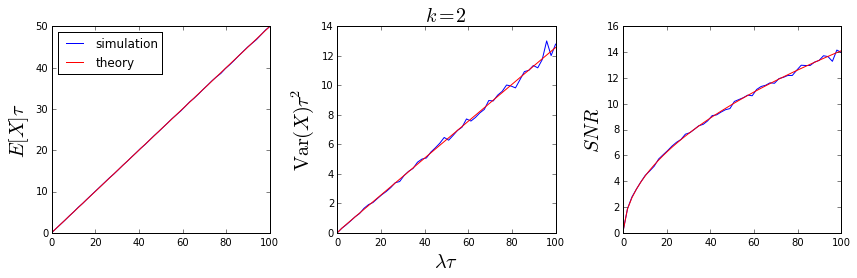

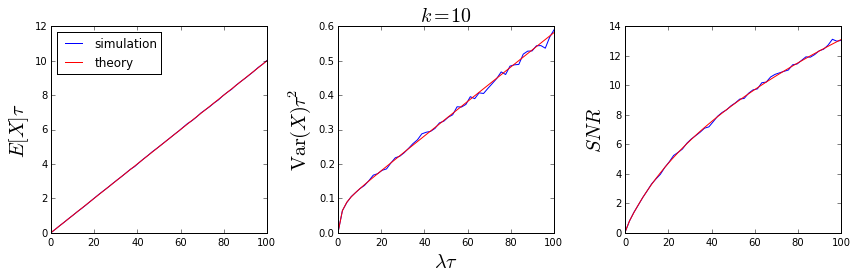

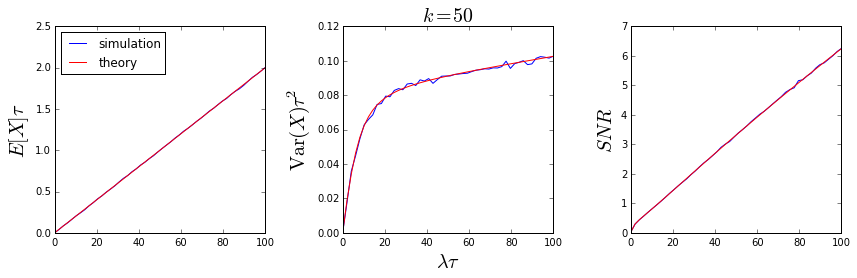

In [4]:
tau = .01
lams = np.linspace(1, 10000, 50)
k_list = [2, 10, 50]
for k in k_list:
    check_theory(lams, k=k, tau=tau, n_trials=100, n_samples=100, k_normalize=False)

# Normalized by $k$

Here we check the theory but make plots normalized by $k$.

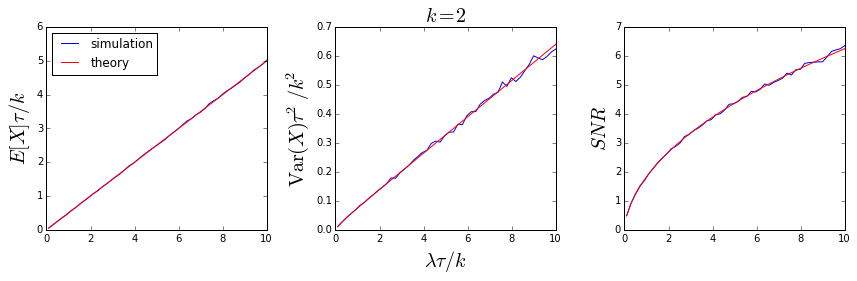

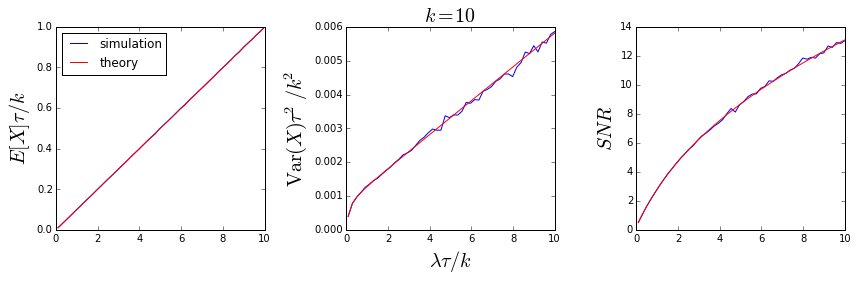

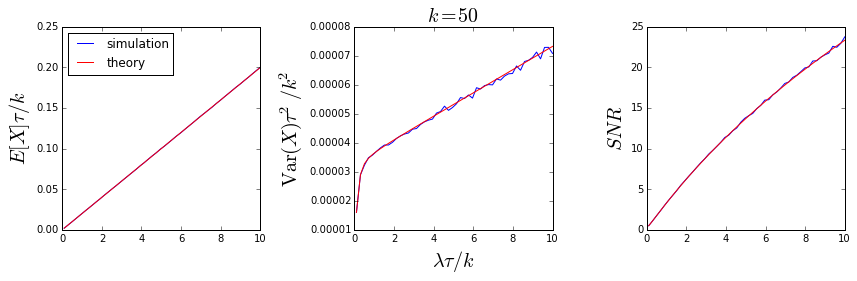

In [5]:
lam_tau_k = np.linspace(.1, 10, 50)
k_list = [2, 10, 50]
for k in k_list:
    lams = lam_tau_k / tau * k
    check_theory(lams, k=k, tau=tau, n_trials=100, n_samples=100, k_normalize=True)

# Comparison with Poisson and Uniform SNR

Above, we found that for a synapse with gamma input,

\begin{equation*}
SNR_g = \frac{\sqrt{2\lambda\tau/k}}
    {\sqrt{\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}}}
\end{equation*}

We also know that for a synapse with Poisson process input (see [here](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/synapse/synapse_SNR_poisson.ipynb)),
\begin{align*}
SNR_{poi} &= \sqrt{2\lambda\tau}
\end{align*}

and that for a synapse with periodic input (see [here](http://nbviewer.ipython.org/github/fragapanagos/notebooks/blob/master/synapse/synapse_SNR_periodic.ipynb)),
\begin{align*}
SNR_{per} &= \frac{1}{\sqrt{\frac{1}{2\lambda\tau}\coth\left(\frac{1}{2\lambda\tau}\right)-1}} \\
 &\approx 
\begin{cases}
\sqrt{12}(\lambda\tau) & \text{at high }\lambda\tau \\
\sqrt{2\lambda\tau} & \textrm{at low }\lambda\tau
\end{cases}
\end{align*}

Now we're in a position to compare how the SNR scales with under these different input statistics.

In [6]:
def th_u_snr(lam, tau):
    x = lam*tau
    ret = 1./np.sqrt(1./(2.*x)*(1+np.exp(-1./x))/(1-np.exp(-1./x))-1)
    return ret

def th_p_snr(lam, tau):
    return np.sqrt(2*lam*tau)

def SNR_den(lt, k):
    a_num = (1.+lt)**k+lt**k
    a_den = (1.+lt)**k-lt**k
    b = 2.*lt/k
    ret = np.sqrt(a_num/a_den-b)
    return ret

def compute_snrs(lt, k, match_output_rate=False):
    if match_output_rate:
        snr_g = th_snr(lt*k, k, 1)
    else:
        snr_g = th_snr(lt, k, 1)
    snr_p = th_p_snr(lt, 1)
    snr_u = th_u_snr(lt, 1)
    return snr_g, snr_p, snr_u
    
def compare_snrs(lam_tau, k, match_output_lam=False, ax=None):
    snr_g, snr_p, snr_u = compute_snrs(lam_tau, k, match_output_lam)
    if ax is None:
        fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(lam_tau, snr_u, 'b', label='periodic')
    ax.plot(lam_tau, snr_p, 'k', label='Poisson')
    ax.plot(lam_tau, snr_g, 'r', label='gamma')
    ax.legend(loc='upper left')
    ax.set_xlabel(r'$\lambda\tau$', fontsize=20)
    ax.set_ylabel(r'$SNR$', fontsize=20)
    ax.set_title(r'$k=%d$' % (k), fontsize=20)

First, we simply decimate the Poisson spike train and only consider every $k$th spike.

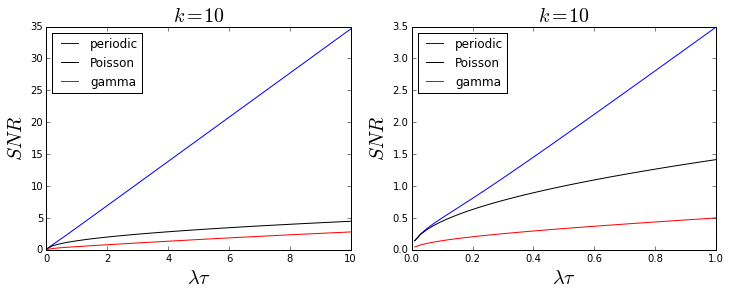

In [7]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
compare_snrs(np.linspace(.01, 10, 50), 10, ax=axs[0])
compare_snrs(np.linspace(.01, 1., 50), 10, ax=axs[1])

By decimating the spike train, the gamma synapse has lower SNR than the Poisson synapse. However, to make this comparison directly, consider the SNR ratio between the Poisson synapse and the gamma synapse.

\begin{equation*}
\frac{SNR_{poi}}{SNR_g} = \sqrt{k\left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}\right)}
\end{equation*}

Plotting this ratio for different $\lambda\tau$ and $k$,

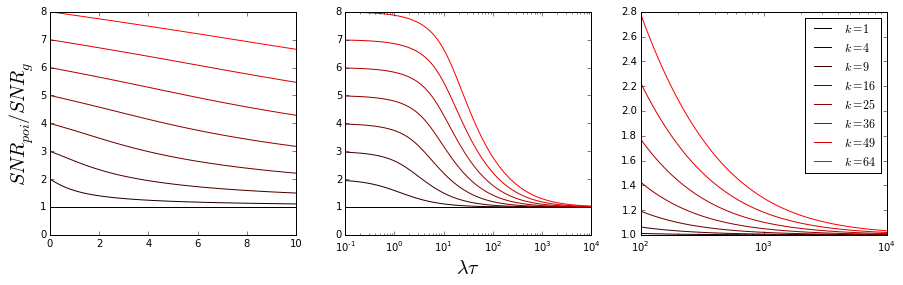

In [3]:
def th_snr_pg(lt, k):
    a_num = (1.+lt)**k+lt**k
    a_den = (1.+lt)**k-lt**k
    b = 2.*lt/k
    ret = np.sqrt(k*(a_num/a_den-b))
    return ret

fig, axs = plt.subplots(ncols=3, figsize=(15,4))
k = np.array([[i**2 for i in xrange(1, 9)]])
nk = k.shape[1]
rcc = [(i/(nk-1.), 0, 0) for i in xrange(nk)]
for ax in axs:
    ax.set_color_cycle(rcc)

lt = np.linspace(0, 10, 100).reshape((-1,1))
snr_pg = th_snr_pg(lt, k)
lines = axs[0].plot(lt, snr_pg)
axs[0].set_ylabel(r'$SNR_{poi}/SNR_g$', fontsize=20)

lt = np.logspace(-1, 4, 100).reshape((-1,1))
snr_pg = th_snr_pg(lt, k)
lines = axs[1].semilogx(lt, snr_pg)
axs[1].set_xlabel(r'$\lambda\tau$', fontsize=20)

lt = np.logspace(2, 4, 100).reshape((-1,1))
snr_pg = th_snr_pg(lt, k)
lines = axs[2].semilogx(lt, snr_pg)
for line, k_val in zip(lines[::1], k[0, ::1]):
    line.set_label(r'$k=%d$' % k_val)
axs[2].legend(loc='upper right');

At $\lambda\tau=0$,

\begin{align*}
\frac{SNR_{poi}}{SNR_g} &= \sqrt{k\left(\frac{(1+0)^k+(0)^k}
    {(1+0)^k-(0)^k} -
    \frac{2\cdot0}{k}\right)} \\
 &= \sqrt{k} \\
\end{align*}

so at low $\lambda\tau$, the gamma synapse has $\sqrt{k}$ lower $SNR$ than the Poisson synapse. This is equivalent to dropping the spike rate to the Poisson synapse by $k$. 

At high $\lambda\tau$, 

\begin{align*}
\lim_{\lambda\tau\rightarrow\infty}\frac{SNR_{poi}}{SNR_g} 
    &= \lim_{\lambda\tau\rightarrow\infty}\sqrt{k\left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}\right)} \\
 &= 1 \\
\end{align*}

(proof [below](#SNR-limit-high-$\lambda\tau$)). In other words, at high $\lambda\tau$, we can send $k$ fewer spikes per second without significantly affecting the SNR.

Next, we match the spike rate of the gamma spikes to match the rates of Poisson and uniform spike trains. That is, we set $\lambda_g = k\lambda$ so that the mean of the synapse receiving gamma distributed spikes matches the mean of the synapse receiving Poisson or uniform spikes.

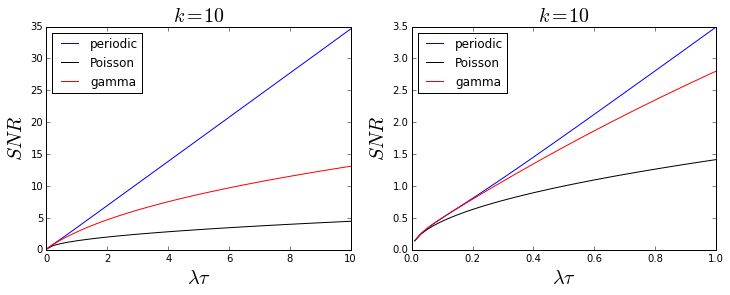

In [9]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
compare_snrs(np.linspace(.01, 10, 50), 10, True, ax=axs[0])
compare_snrs(np.linspace(.01, 1., 50), 10, True, ax=axs[1])

Matching the rate of spikes that actually reach the synapse, we see that the gamma distributed spikes improves upon the SNR of the Poisson synapse. To see why, we can plot the denominator of $SNR_g$:

\begin{equation*}
\sqrt{\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
{(1+\lambda\tau)^k-(\lambda\tau)^k} -
\frac{2\lambda\tau}{k}}
\end{equation*}

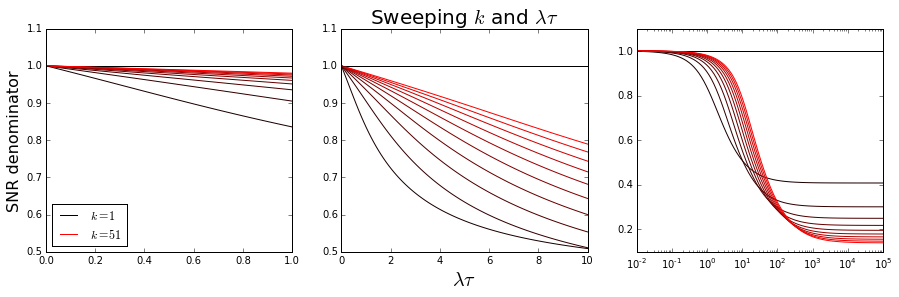

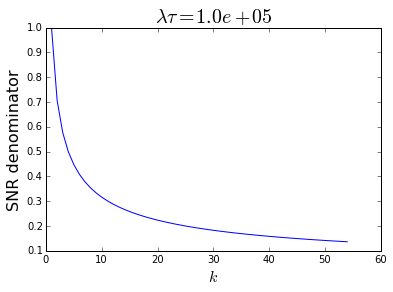

In [12]:
fig, axs = plt.subplots(ncols=3, figsize=(15,4))
kstep = 5
kmax = 55
nk = kmax/kstep
k = np.arange(1, kmax, kstep).reshape((1,-1))
rcc = [(i/(nk-1.), 0, 0) for i in xrange(nk)]
for ax in axs:
    ax.set_color_cycle(rcc)

lt = np.linspace(0, 1, 100).reshape((-1,1))
snr_den = SNR_den(lt, k)
lines = axs[0].plot(lt, snr_den)
lines[0].set_label(r'$k=%d$' % k[0,0])
lines[-1].set_label(r'$k=%d$' % k[0,-1])
axs[0].legend(loc='lower left')
axs[0].set_ylabel('SNR denominator', fontsize=16)

lt = np.linspace(0, 10, 100).reshape((-1,1))
snr_den = SNR_den(lt, k)
lines = axs[1].plot(lt, snr_den)
axs[1].set_xlabel(r'$\lambda\tau$', fontsize=20)
axs[1].set_title(r'Sweeping $k$ and $\lambda\tau$', fontsize=20)

lt = np.logspace(-2, 5, 100).reshape((-1,1))
snr_den = SNR_den(lt, k)
lines = axs[2].semilogx(lt, snr_den)

axs[0].set_ylim(axs[1].get_ylim())

k = np.arange(1, kmax).reshape((1,-1))
snr_den = SNR_den(lt, k)
fig, ax = plt.subplots()
ax.plot(k[0,:], snr_den[-1,:])
ax.set_xlabel(r'$k$', fontsize=16)
ax.set_ylabel('SNR denominator', fontsize=16)
ax.set_title(r'$\lambda\tau=%.1e$' % lt[-1], fontsize=20);

Since the denominator is less than $1$, the gamma synapse SNR is higher than the Poisson synapse.

# Cost to match SNR

What rates do we need to acheive a given SNR?
 - input rate of accumulator
 - output rate of accumulator

What is the cost per input spike? What is the cost per output spike?

What is the cost per memory lookup? What is the cost per long-distance transmission?

# Appendix

## Supplementary derivations

For $E\left[e^{-2T/\tau}\right]$ and $E\left[e^{-T/\tau}\right]$, or rather $E\left[e^{-cT/\tau}\right]$.

\begin{align*}
E[e^{-cT/\tau}] &= \int_{-\infty}^{\infty}e^{-ct/\tau}f_T(t)dt \\
 &= \int_{0}^{\infty}e^{-ct/\tau}\frac{\lambda^k}{\Gamma(k)}t^{k-1}e^{-\lambda t}dt \\
 &= \frac{\lambda^k}{\Gamma(k)}\int_{0}^{\infty}t^{k-1}e^{-ct/\tau}e^{-\lambda t}dt \\
 &= \frac{\lambda^k}{\Gamma(k)}\int_{0}^{\infty}t^{k-1}e^{-t(c/\tau+\lambda)}dt \\
 &= \frac{\lambda^k}{\Gamma(k)}\int_{0}^{\infty}\left(\frac{\tau}{c+\lambda\tau}u\right)^{k-1}
     e^{-u}\frac{\tau}{c+\lambda\tau}du & u = t(c/\tau+\lambda) \\
 &= \frac{\lambda^k}{\Gamma(k)}\int_{0}^{\infty}\left(\frac{\tau}{c+\lambda\tau}\right)^ku^{k-1}e^{-u}du \\
 &= \frac{\lambda^k}{\Gamma(k)}\left(\frac{\tau}{c+\lambda\tau}\right)^k\int_{0}^{\infty}u^{k-1}e^{-u}du \\
 &= \frac{\lambda^k}{\Gamma(k)}\left(\frac{\tau}{c+\lambda\tau}\right)^k\Gamma(k) \\
 &= \left(\frac{\lambda\tau}{c+\lambda\tau}\right)^k \\
\end{align*}

---

For $E\left[e^{-2T_1/\tau}\right]$ and $E\left[e^{-T_1/\tau}\right]$, or rather $E\left[e^{-cT_1/\tau}\right]$.

$T_1=UT^*$ where $U\sim\mathrm{Uniform}(0,1)$ and $f_{T^*}(t)=\frac{tf_T(t)}{E[T]}$,

\begin{align*}
E\left[e^{-cT_1/\tau}\right] &= E\left[e^{-cUT^*/\tau}\right] \\
 &= E\left[E\left[e^{-cUT^*/\tau}|T^*\right]\right] \\
 &= E\left[\int_0^1e^{-cuT^*/\tau}du\right] \\
 &= E\left[-\frac{\tau}{cT^*}\left[e^{-cuT^*/\tau}\right]_0^1\right] \\
 &= E\left[\frac{\tau}{cT^*}\left(1-e^{-cT^*/\tau}\right)\right] \\
 &= \frac{\tau}{c}\int_{-\infty}^{\infty}\frac{1}{t}\left(1-e^{-ct/\tau}\right)f_{T^*}(t)dt \\
 &= \frac{\tau}{c}\int_{-\infty}^{\infty}\frac{1}{t}\left(1-e^{-ct/\tau}\right)\frac{tf_{T}(t)}{E[T]}dt \\
 &= \frac{\tau}{cE[T]}\int_{-\infty}^{\infty}\left(1-e^{-t/\tau}\right)f_{T}(t)dt \\
 &= \frac{\lambda\tau}{ck}\left(1-E\left[e^{-cT/\tau}\right]\right) \\
 &= \frac{\lambda\tau}{ck}\left(1-\left(\frac{\lambda\tau}{c+\lambda\tau}\right)^k\right) \\
\end{align*}

---

If we assume that the ISI containing the current time is unbiased and approximate $T^*=T$,

\begin{align*}
E\left[\frac{1}{cT}\left(1-e^{-cT/\tau}\right)\right] &= 
    \int_{-\infty}^{\infty}\frac{1}{ct}\left(1-e^{-ct/\tau}\right)f_T(t)dt \\
 &= \int_0^{\infty}\frac{1}{ct}\left(1-e^{-ct/\tau}\right)
    \frac{\lambda^k}{\Gamma(k)}t^{k-1}e^{-\lambda t}dt \\
 &= \frac{\lambda^k}{c\Gamma(k)}\int_0^{\infty}\frac{1}{t}\left(1-e^{-ct/\tau}\right)
    t^{k-1}e^{-\lambda t}dt \\
 &\ldots & \mathrm{Mathematica} \\
 &= \frac{\lambda^k}{c\Gamma(k)}\frac{\Gamma(k-1)}{\lambda^{k-1}}
    \frac{(c+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(c+\lambda\tau)^{k-1}} \\
 &= \frac{\lambda}{c(k-1)}
    \frac{(c+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(c+\lambda\tau)^{k-1}} \\
\end{align*}

---

# Approximations

In this section, we will use some approximations to derive the mean, variance and SNR.

## Assuming process is memoryless

Accounting for the nonmemorylessness of the gamma renewal process makes for ugly derivations. Here we compute the synaptic statistics assuming it is memoryless. This will give us approximations to the actual statistics.

### Synapse mean

\begin{align*}
E[X] &= \frac{1}{\tau}\sum_{i=1}^\infty E\left[e^{-T/\tau}\right]^i \\
 &= \frac{1}{\tau}\sum_{i=1}^\infty \left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{ki} \\
 &= \frac{1}{\tau}\frac{\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k}
    {1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^k} \\
 &= \frac{1}{\tau}\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k} \\
\end{align*}

### Syanpse variance

\begin{align*}
E[X^2] &= \frac{1}{\tau^2}\sum_{i=1}^{\infty}E\left[e^{-2T/\tau}\right]^i\left(1 +
    2\sum_{j=1}^{\infty}E\left[e^{-T/\tau}\right]^{j}\right) \\
 &=  \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k}\left(1 +
    2\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k}
    \frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k} \\
\end{align*}

\begin{align*}
\Var(X) &= E[X^2] - E[X]^2 \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k}
    \frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{1}{\tau^2}\left(\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right)^2 \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}
    \left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}
    \left(\frac{\left((1+\lambda\tau)^k+(\lambda\tau)^k\right)\left((1+\lambda\tau)^k-(\lambda\tau)^k\right) -
    (\lambda\tau)^k\left((2+\lambda\tau)^k-(\lambda\tau)^k\right)}
    {\left((2+\lambda\tau)^k-(\lambda\tau)^k\right)\left((1+\lambda\tau)^k-(\lambda\tau)^k\right)}\right) \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{\left((1+\lambda\tau)^k-(\lambda\tau)^k\right)^2}
    \left(\frac{(1+\lambda\tau)^{2k}-(\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k+(\lambda\tau)^{2k}}
    {(2+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
 &= \frac{1}{\tau^2}\frac{(\lambda\tau)^k}{\left((1+\lambda\tau)^k-(\lambda\tau)^k\right)^2}
    \left(\frac{(1+\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k}
    {(2+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
\end{align*}

### Synapse SNR

\begin{align*}
SNR &= \frac{E[X]}{\sqrt{\Var(X)}} \\
 &= \frac{\frac{1}{\tau}\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}}
    {\sqrt{\frac{1}{\tau^2}\frac{(\lambda\tau)^k}{\left((1+\lambda\tau)^k-(\lambda\tau)^k\right)^2}
    \left(\frac{(1+\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k}
    {(2+\lambda\tau)^k-(\lambda\tau)^k}\right)}} \\
 &= \frac{\sqrt{(\lambda\tau)^k}}
    {\sqrt{
    \frac{(1+\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k}
    {(2+\lambda\tau)^k-(\lambda\tau)^k}}} \\
 &= \sqrt{\frac{-(\lambda\tau)^{2k}+(\lambda\tau)^k(2+\lambda\tau)^k}
    {(1+\lambda\tau)^{2k} -
    (\lambda\tau)^k(2+\lambda\tau)^k}} \\
\end{align*}

---

## Assuming unbiased first interval

Accounting for the bias in $T^*$ produces a distribution that's hard to analyze, here, we assume that $T^*$ follows the same distribution as $T$.

### Synapse mean

\begin{align*}
E[X] &= \frac{1}{\tau}E\left[e^{-T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-T/\tau}\right]^i \\
 &= \frac{1}{\tau}E\left[\frac{\tau}{T}\left(1-e^{-T/\tau}\right)\right]
    \sum_{i=0}^{\infty}\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{ki} \\
 &= \frac{\lambda}{k-1}\left(\frac{(1+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(1+\lambda\tau)^{k-1}}\right)
    \frac{1}{1-\left(\frac{\lambda\tau}{1+\lambda\tau}\right)^{k}} \\
 &= \frac{\lambda}{k-1}\left(\frac{(1+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(1+\lambda\tau)^{k-1}}\right)
    \frac{\left(1+\lambda\tau\right)^k}{\left(1+\lambda\tau\right)^k-\left(\lambda\tau\right)^k} \\
 &= \frac{\lambda(1+\lambda\tau)}{k-1}\frac{(1+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} \\
\end{align*}

### Synapse variance

\begin{align*}
E[X^2] &= \frac{1}{\tau^2}E\left[e^{-2T_1/\tau}\right]\sum_{i=0}^{\infty}E\left[e^{-2T/\tau}\right]^i
    \left(1 + 2\sum_{j=1}^{\infty}E\left[e^{-T/\tau}\right]^j\right) \\
&= \frac{1}{\tau^2}E\left[\frac{\tau}{2T}\left(1-e^{-2T/\tau}\right)\right]
    \sum_{i=0}^{\infty}\left(\frac{\lambda\tau}{2+\lambda\tau}\right)^{ki}
    \left(1 + 2\frac{(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
&= \frac{1}{\tau}\left(
    \frac{\lambda}{2(k-1)}
    \frac{(2+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(2+\lambda\tau)^{k-1}}\right)
    \frac{(2+\lambda\tau)^k}{(2+\lambda\tau)^k-(\lambda\tau)^k}
    \left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
&= \frac{\lambda}{\tau}\frac{2+\lambda\tau}{2(k-1)}\left(
    \frac{(2+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(2+\lambda\tau)^k-(\lambda\tau)^k}\right)
    \left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) \\
\end{align*}

\begin{align*}
\Var(X) &= \frac{\lambda}{\tau}\frac{2+\lambda\tau}{2(k-1)}\left(
    \frac{(2+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}{(2+\lambda\tau)^k-(\lambda\tau)^k}\right)
    \left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}{(1+\lambda\tau)^k-(\lambda\tau)^k}\right) -
    \left(\frac{\lambda(1+\lambda\tau)}{k-1}\frac{(1+\lambda\tau)^{k-1}-(\lambda\tau)^{k-1}}
    {(1+\lambda\tau)^k-(\lambda\tau)^k}\right)^2 \\
\end{align*}

### Synapse SNR

\begin{align*}
SNR &= \text{...something ugly}
\end{align*}

---

In [11]:
def th_mean_memoryless(lam, k, tau):
    x = lam*tau
    ret = x**k/((1+x)**k-x**k)/tau
    return ret

def th_mean_no_bias(lam, k, tau):
    x = lam*tau
    a = lam/(k-1)
    b = 1+x
    c_num = (1+x)**(k-1)-x**(k-1)
    c_den = (1+x)**k-x**k
    c = c_num/c_den
    ret = a*b*c
    return ret

def th_var_memoryless(lam, k, tau):
    x = lam*tau
    a = 1./tau**2    
    b = x**k/((1+x)**k-x**k)**2
    c_num = (1+x)**(2*k) - x**k*(2+x)**k
    c_den = (2+x)**k - x**k
    c = c_num/c_den
    ret = a*b*c
    return ret

def th_var_no_bias(lam, k, tau):
    def th_E2(lam, k, tau):
        x = lam*tau
        a = lam/tau
        b = (2+x)/(2.*(k-1))
        c_num = (2+x)**(k-1)-x**(k-1)
        c_den = (2+x)**k-x**k
        c = c_num/c_den
        d_num = (1+x)**k+x**k
        d_den = (1+x)**k-x**k
        d = d_num/d_den
        ret = a*b*c*d
        return ret
    ret = th_E2(lam, k, tau) - th_mean_no_bias(lam, k, tau)**2
    return ret

In [12]:
def theory_vs_approx(lams, k, tau=.01, k_normalize=False):
    mean_th = th_mean(lams, k, tau)
    mean_th_memoryless = th_mean_memoryless(lams, k, tau)
    mean_th_no_bias = th_mean_no_bias(lams, k, tau)
    
    var_th = th_var(lams, k, tau)
    var_th_memoryless = th_var_memoryless(lams, k, tau)
    var_th_no_bias = th_var_no_bias(lams, k, tau)
    
    snr_th = get_snr(mean_th, var_th) 
    snr_th_memoryless = get_snr(mean_th_memoryless, var_th_memoryless)
    snr_th_no_bias = get_snr(mean_th_no_bias, var_th_no_bias)
    
    fig, axs = plt.subplots(ncols=3, figsize=(12,4), sharex=True)
    
    x = lams*tau
    if k_normalize:
        x /= k
        mean_th /= k
        mean_th_memoryless /= k
        mean_th_no_bias /= k
        var_th /= k**2
        var_th_memoryless /= k**2
        var_th_no_bias /= k**2

    axs[0].plot(x, mean_th*tau, 'r', label='theory')
    axs[0].plot(x, mean_th_memoryless*tau, 'g', label='memoryless')
    axs[0].plot(x, mean_th_no_bias*tau, 'c', label='no bias')
    axs[0].legend(loc='upper left', fontsize=12)

    
    axs[1].plot(x, var_th*tau**2, 'r', label='theory')
    axs[1].plot(x, var_th_memoryless*tau**2, 'g', label='memoryless')
    axs[1].plot(x, var_th_no_bias*tau**2, 'c', label='no bias')
    axs[1].set_title(r'$k=%d$' % k, fontsize=20)
    
    axs[2].plot(x, snr_th, 'r', label='theory')
    axs[2].plot(x, snr_th_memoryless, 'g', label='memoryless')
    axs[2].plot(x, snr_th_no_bias, 'c', label='no bias')

    axs[2].set_ylabel(r'$SNR$', fontsize=20)
    
    if k_normalize:
        axs[0].set_ylabel(r'$E[X]\tau/k$', fontsize=20)
        axs[1].set_xlabel(r'$\lambda\tau/k$', fontsize=20)
        axs[1].set_ylabel(r'$\operatorname{Var}(X)\tau^2/k^2$', fontsize=20)
    else:
        axs[0].set_ylabel(r'$E[X]\tau$', fontsize=20)
        axs[1].set_xlabel(r'$\lambda\tau$', fontsize=20)
        axs[1].set_ylabel(r'$\operatorname{Var}(X)\tau^2$', fontsize=20)

    plt.tight_layout()

# Unnormalized by $k$

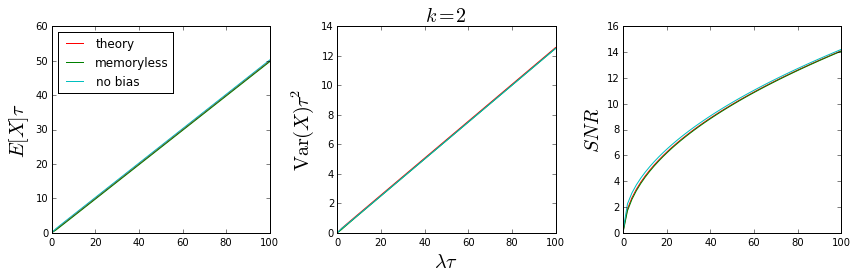

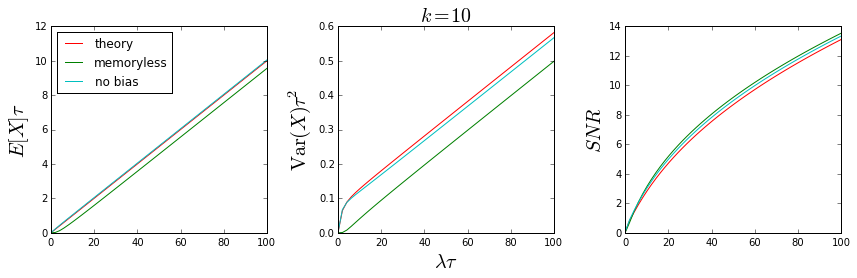

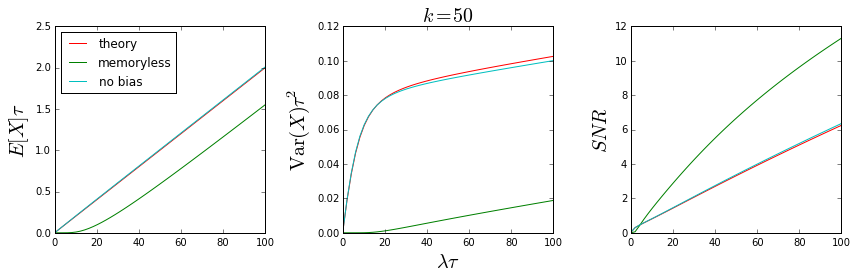

In [13]:
lams = np.linspace(1, 10000, 50)
k_list = [2, 10, 50]
for k in k_list:
    theory_vs_approx(lams, k=k, tau=tau, k_normalize=False)

# Normalized by $k$

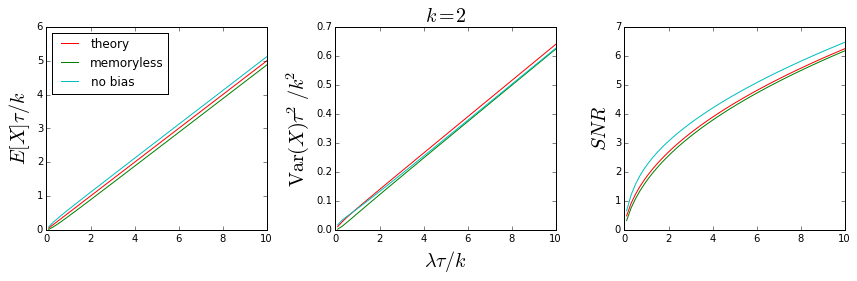

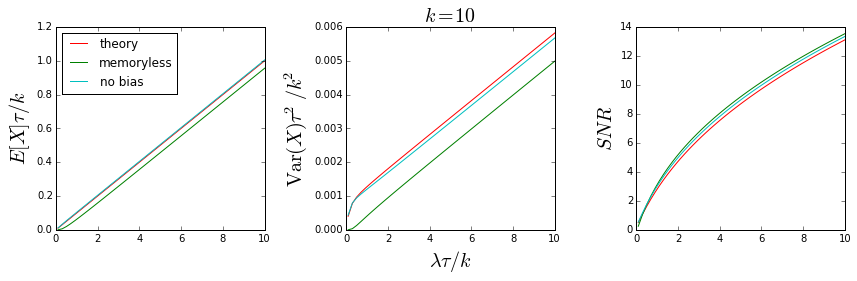

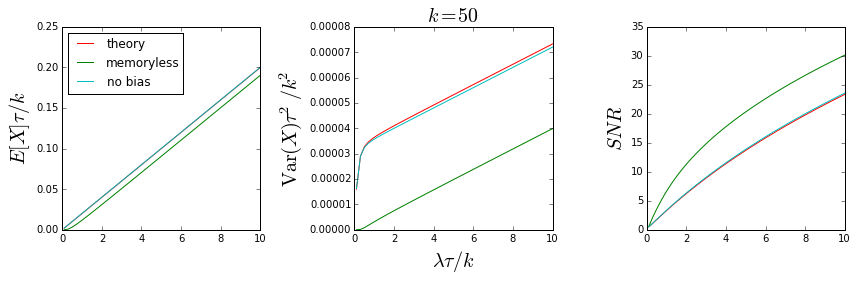

In [14]:
tau = .01
lam_tau_k = np.linspace(.1, 10, 50)
k_list = [2, 10, 50]
for k in k_list:
    lams = lam_tau_k / tau * k
    theory_vs_approx(lams, k=k, tau=tau, k_normalize=True)

## $T_1$ Verification

Here we check that indeed $T_1$ can be expressed as $UT^*$.

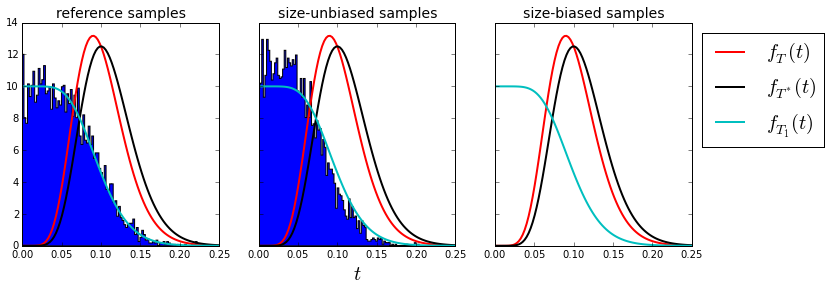

In [15]:
def check_T1(lam, k, n_trials=5000, n_intervals=10000):
    # generate spike times
    # sample within time to pick T1
    isi = rng.gamma(k, 1./lam, n_intervals)
    spike_times = np.cumsum(isi)
    t_vals = rng.uniform(0, spike_times[-1], n_trials)
    t1 = np.zeros(n_trials)
    for idx, t in enumerate(t_vals):
        x = spike_times-t
        t1[idx] = x[x>=0][0]
    
    # sample gamma to generate an interval
    # sample from uniform within that gama to generate t
    t = rng.gamma(k, 1./lam, n_trials)
    tfrac = rng.uniform(0, 1, n_trials)
    t1_unbiased = t*tfrac
    
    t1_biased = None
    
    fig, axs = plt.subplots(ncols=3, figsize=(12,4), sharex=True, sharey=True)
    
    axs[0].hist(t1, bins=100, histtype='stepfilled', normed=True)
    axs[1].hist(t1_unbiased, bins=100, histtype='stepfilled', normed=True)
    
    rv = gamma(k, scale=1./lam)
    xlims = axs[0].get_xlim()
    T = np.linspace(xlims[0], xlims[1], 100)
    T_pdf = rv.pdf(T)
    Tb_pdf = T*T_pdf/rv.mean()
    T1_pdf = (1-rv.cdf(T))/rv.mean()
    for ax in axs:
        ax.plot(T, T_pdf, 'r', lw=2, label=r'$f_T(t)$')
        ax.plot(T, Tb_pdf, 'k', lw=2, label=r'$f_{T^*}(t)$')
        ax.plot(T, T1_pdf, 'c', lw=2, label=r'$f_{T_1}(t)$')
    
    axs[2].legend(loc='upper left', bbox_to_anchor=(1,1), fontsize=20)
    axs[1].set_xlabel(r'$t$', fontsize=20)
    axs[0].set_title('reference samples', fontsize=14)
    axs[1].set_title('size-unbiased samples', fontsize=14)
    axs[2].set_title('size-biased samples', fontsize=14)
    
    
check_T1(100, 10)

## The gamma distribution

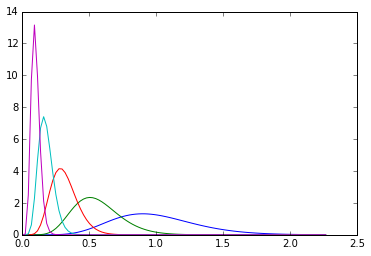

In [16]:
# make look like a delta function
k = 10
N = 5
lams = 10**(np.linspace(1,2,N))
t_max = gamma.ppf(.999, k, scale=1./min(lams))
t = np.linspace(0, t_max, 100)
fig, ax = plt.subplots()
for lam in lams:
    pdf = gamma.pdf(t, k, scale=1./lam)
    ax.plot(t, pdf)

Gamma distribution statistics:

$$
E[X] = \frac{k}{\lambda}
$$

$$
\Var(x) = \frac{k}{\lambda^2}
$$

\begin{align*}
SNR &= \frac{\frac{k}{\lambda}}{\sqrt{\frac{k}{\lambda^2}}} \\
 &= \sqrt{k}
\end{align*}

Therefore 

$$k=(SNR)^2$$

To hit a desired output rate $\lambda_{out}$ with input rate $\lambda$,

\begin{align*}
\lambda_{out} &= \frac{1}{E[X]} \\
 &= \frac{\lambda}{k} \\
\lambda &= k\lambda_{out} \\
\lambda &= (SNR)^2\lambda_{out} \\
\end{align*}

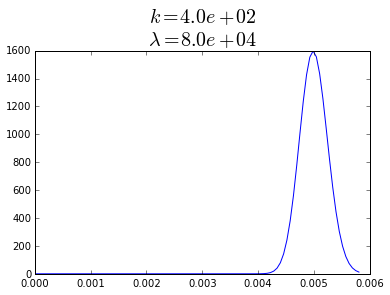

In [17]:
# let's say I wanted it to spike with a certain frequency and certain variance
def find_inputs(out_lam, out_snr):
    k = out_snr**2.
    lam = k*out_lam
    return k, lam

k, lam = find_inputs(200, 20)
t_max = gamma.ppf(.999, k, scale=1./lam)
t = np.linspace(0, t_max, 100)
pdf = gamma.pdf(t, k, scale=1./lam)
plt.plot(t, pdf)
plt.title('$k=%.1e$\n$\lambda=%.1e$' % (k, lam), fontsize=20)

## SNR limit high $\lambda\tau$

Here we consider

\begin{equation*}
SNR = 
\frac{\sqrt{2\lambda\tau}}
    {\sqrt{k\left(\frac{(1+\lambda\tau)^k+(\lambda\tau)^k}
    {(1+\lambda\tau)^k-(\lambda\tau)^k} -
    \frac{2\lambda\tau}{k}\right)}} \\
\end{equation*}

in the limit of high $\lambda\tau$. We only need to consider the terms in the square root.
Let $x=\lambda\tau$,

\begin{align*}
k\left(\frac{(1+x)^k+x^k}{(1+x)^k-x^k} - \frac{2x}{k}\right)
 &= k\frac{x^k(1/x+1)^k+x^k}{x^k(1/x+1)^k-x^k} - 2x \\
 &= k\frac{(1/x+1)^k+1}{(1/x+1)^k-1} - 2x \\
 &= k\frac{\left(\frac{1}{x}+1\right)^k+1}
    {\left(\frac{1}{x}+1\right)^k-1} - 2x \\
 &= k\frac{\binom{k}{0}\left(\frac{1}{x}\right)^k+\binom{k}{1}\left(\frac{1}{x}\right)^{k-1}+
    \ldots+\binom{k}{k-1}\frac{1}{x}+\binom{k}{k}1+1}
    {\binom{k}{0}\left(\frac{1}{x}\right)^k+\binom{k}{1}\left(\frac{1}{x}\right)^{k-1}+
    \ldots+\binom{k}{k-1}\frac{1}{x}+\binom{k}{k}1-1} - 2x \\
 &= k\frac{\left(\frac{1}{x}\right)^k+k\left(\frac{1}{x}\right)^{k-1}+
    \ldots+k\frac{1}{x}+2}
    {\left(\frac{1}{x}\right)^k+k\left(\frac{1}{x}\right)^{k-1}+
    \ldots+k\frac{1}{x}} - 2x \\
 &= k\frac{x}{x}\frac{\left(\frac{1}{x}\right)^k+k\left(\frac{1}{x}\right)^{k-1}+
    \ldots+k\frac{1}{x}+2}
    {\left(\frac{1}{x}\right)^k+k\left(\frac{1}{x}\right)^{k-1}+
    \ldots+k\frac{1}{x}} - 2x \\
 &= \frac{\left(\frac{1}{x}\right)^{k-1}+k\left(\frac{1}{x}\right)^{k-2}+\ldots+k+2x}
    {\frac{1}{k}\left(\frac{1}{x}\right)^{k-1}+\left(\frac{1}{x}\right)^{k-2}+\ldots+
    \frac{1}{k}\binom{k}{k-2}\left(\frac{1}{x}\right)+1} - 2x \\
 &= \frac{\left(\frac{1}{x}\right)^{k-1}+k\left(\frac{1}{x}\right)^{k-2}+\ldots+k+2x}
    {\frac{1}{k}\left(\frac{1}{x}\right)^{k-1}+\left(\frac{1}{x}\right)^{k-2}+\ldots+
    \frac{k-1}{2}\left(\frac{1}{x}\right)+1} - 2x \\
 &= \frac{\left(\frac{1}{x}\right)^{k-1}+k\left(\frac{1}{x}\right)^{k-2}+\ldots+k+2x-
    2x\left(\frac{1}{k}\left(\frac{1}{x}\right)^{k-1}+\left(\frac{1}{x}\right)^{k-2}+\ldots+
    \frac{k-1}{2}\left(\frac{1}{x}\right)+1\right)}
    {\frac{1}{k}\left(\frac{1}{x}\right)^{k-1}+\left(\frac{1}{x}\right)^{k-2}+\ldots+
    \frac{k-1}{2}\left(\frac{1}{x}\right)+1} \\
 &= \frac{\left(\frac{1}{x}\right)^{k-1}+k\left(\frac{1}{x}\right)^{k-2}+\ldots+k+2x-
    \frac{2}{k}\left(\frac{1}{x}\right)^{k-2}-2\left(\frac{1}{x}\right)^{k-3}-\ldots-(k-1)-2x}
    {\frac{1}{k}\left(\frac{1}{x}\right)^{k-1}+\left(\frac{1}{x}\right)^{k-2}+\ldots+
    \frac{k-1}{2}\left(\frac{1}{x}\right)+1} \\
 &= \frac{\left(\frac{1}{x}\right)^{k-1}+(k-\frac{2}{k})\left(\frac{1}{x}\right)^{k-2}+\ldots+1}
    {\frac{1}{k}\left(\frac{1}{x}\right)^{k-1}+\left(\frac{1}{x}\right)^{k-2}+\ldots+
    \frac{k-1}{2}\left(\frac{1}{x}\right)+1} \\
\end{align*}

Taking the $\lim_{x\rightarrow\infty}$, we see that the $\frac{1}{x}$ terms will tend to zero,

\begin{equation*}
\lim_{x\rightarrow\infty}
    \frac{\left(\frac{1}{x}\right)^{k-1}+(k-\frac{2}{k})\left(\frac{1}{x}\right)^{k-2}+\ldots+1}
    {\frac{1}{k}\left(\frac{1}{x}\right)^{k-1}+\left(\frac{1}{x}\right)^{k-2}+\ldots+
    \frac{k-1}{2}\left(\frac{1}{x}\right)+1} = 1
\end{equation*}

Therefore, at high $\lambda\tau$,

\begin{equation*}
SNR = \sqrt{2\lambda\tau}
\end{equation*}